In [1]:
import os
import json
import re
from io import BytesIO
from pathlib import Path

import numpy as np
import pandas as pd
from google.cloud import storage

In [2]:
def load_environment(env_path: str = ".env") -> tuple[str, str]:
    """Load GCP credentials and bucket name from a .env file (supports running from notebooks/)."""
    env_file = Path(env_path)

    # If running from notebooks/, fall back to parent .env
    if not env_file.is_file() and env_path == ".env":
        parent_env = Path.cwd().parent / ".env"
        if parent_env.is_file():
            env_file = parent_env

    if not env_file.is_file():
        raise FileNotFoundError(f".env file not found at {env_file}")

    for line in env_file.read_text().splitlines():
        stripped = line.strip()
        if not stripped or stripped.startswith("#") or "=" not in stripped:
            continue
        key, value = stripped.split("=", 1)
        key = key.strip()
        value = value.strip()
        if key in {"GOOGLE_APPLICATION_CREDENTIALS", "GCP_BUCKET_NAME"}:
            os.environ[key] = value

    credentials_path = os.environ.get("GOOGLE_APPLICATION_CREDENTIALS")
    bucket_name = os.environ.get("GCP_BUCKET_NAME")

    if not credentials_path or not bucket_name:
        raise EnvironmentError(
            "GOOGLE_APPLICATION_CREDENTIALS and GCP_BUCKET_NAME must be set in the .env file."
        )

    credentials_file = Path(credentials_path)
    if not credentials_file.is_file():
        raise FileNotFoundError(f"Credentials file not found at {credentials_file}")

    print(f"Loaded credentials from: {credentials_file}")
    print(f"Using bucket: {bucket_name}")
    return str(credentials_file), bucket_name


In [3]:
def load_emg_dataframe_from_csv(env_path: str = ".env") -> pd.DataFrame:
    """Download the EMG CSV from GCS and return the raw DataFrame."""
    _, bucket_name = load_environment(env_path=env_path)

    client = storage.Client()
    bucket = client.bucket(bucket_name)
    blob_path = "EMG-nature/Clean_df/emg_trial_level_df.csv"

    print(f"Accessing blob: {blob_path}")
    blob = bucket.blob(blob_path)

    if not blob.exists(client=client):
        raise FileNotFoundError(f"Blob {blob_path} not found in bucket {bucket_name}")

    data_bytes = blob.download_as_bytes()
    print(f"Downloaded {len(data_bytes)} bytes from GCS")

    df = pd.read_csv(BytesIO(data_bytes))
    print(f"Loaded DataFrame with shape: {df.shape}")
    return df


In [4]:
def parse_signal_cell(cell: str | np.ndarray | list | tuple) -> np.ndarray:
    """Parse a corrupted/loosely formatted signal into a (16, N) float32 array."""
    # If already array-like, trust and reshape as needed.
    if isinstance(cell, (np.ndarray, list, tuple)):
        arr = np.asarray(cell, dtype=np.float32)
        if arr.shape == (16, 10000):
            return arr
        if arr.shape == (10000, 16):
            return arr.T
        if arr.ndim == 1 and arr.size == 160000:
            return arr.reshape(16, 10000)
        if arr.ndim == 2 and arr.shape[0] == 16:
            return arr

    raw = str(cell)
    tokens = re.findall(r"[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?", raw)
    if not tokens:
        raise ValueError(f"No numeric tokens found in signal cell: {raw[:120]}")

    numbers = np.asarray([float(t) for t in tokens], dtype=np.float32)
    if numbers.size < 16:
        raise ValueError(f"Too few numeric tokens ({numbers.size}); sample: {raw[:120]}")

    usable = (numbers.size // 16) * 16
    numbers = numbers[:usable]
    channel_len = usable // 16
    if channel_len == 0:
        raise ValueError(f"Not enough data to form 16 channels; tokens={numbers.size}")

    arr = numbers.reshape(16, channel_len)
    return arr


def fix_length(arr: np.ndarray, target_len: int = 10000) -> np.ndarray:
    """Trim or pad signals to exactly (16, target_len)."""
    if arr.ndim != 2 or arr.shape[0] != 16:
        raise ValueError(f"Signal must have shape (16, N); got {arr.shape}")

    current_len = arr.shape[1]
    if current_len == target_len:
        return arr
    if current_len < target_len:
        pad_width = target_len - current_len
        return np.pad(arr, ((0, 0), (0, pad_width)), mode="constant")
    return arr[:, :target_len]


In [5]:
emg_df = load_emg_dataframe_from_csv()

emg_df["signal"] = emg_df["signal"].apply(parse_signal_cell)
emg_df["signal_fixed"] = emg_df["signal"].apply(fix_length)

print(emg_df["signal_fixed"].apply(lambda x: x.shape).value_counts())
print(emg_df.head())
print(emg_df.shape)


FileNotFoundError: .env file not found at .env

In [6]:
emg_df = emg_df.drop(columns = "Unnamed: 0")

In [7]:
emg_df.head()

,participant,day,block,trial_id,position,grasp,signal,signal_fixed
0,1,1,1,1,2,3,"[[3.763498e-05, 1.9842508e-05], [9.071698e-06,...","[[3.763498e-05, 1.9842508e-05, 0.0, 0.0, 0.0, ..."
1,1,1,1,2,2,3,"[[1.0537988e-05, 1.153949e-05], [1.18090165e-0...","[[1.0537988e-05, 1.153949e-05, 0.0, 0.0, 0.0, ..."
2,1,1,1,3,2,3,"[[1.6977565e-05, 1.9937088e-05], [2.1830994e-0...","[[1.6977565e-05, 1.9937088e-05, 0.0, 0.0, 0.0,..."
3,1,1,1,4,2,3,"[[3.6807487e-06, 3.2587977e-06], [2.339907e-06...","[[3.6807487e-06, 3.2587977e-06, 0.0, 0.0, 0.0,..."
4,1,1,1,5,2,3,"[[1.5383765e-05, 1.8471881e-05], [1.6300444e-0...","[[1.5383765e-05, 1.8471881e-05, 0.0, 0.0, 0.0,..."


In [8]:
grasp_groups = emg_df.groupby('grasp')


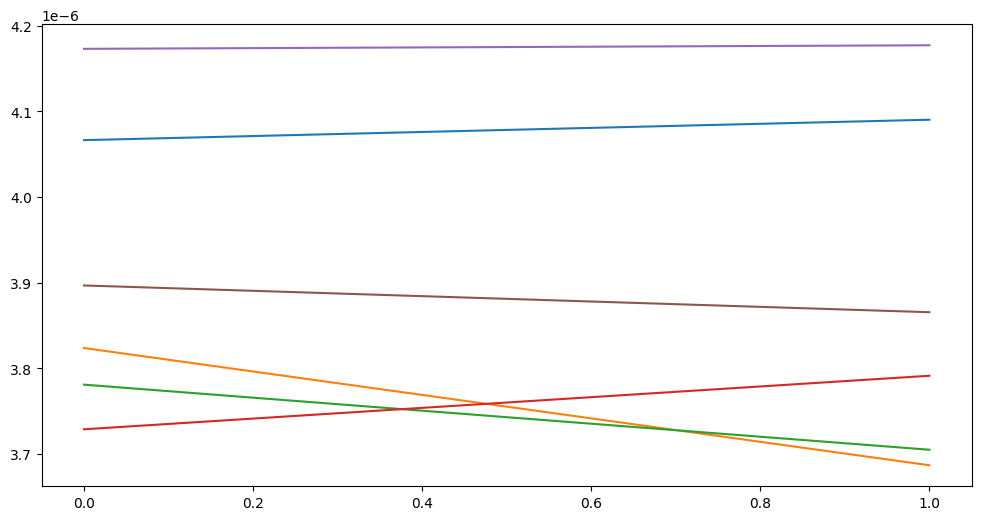

In [9]:
import numpy as np
import matplotlib.pyplot as plt

grasp_groups = emg_df.groupby('grasp')

plt.figure(figsize=(12, 6))

for grasp, group in grasp_groups:
    # Stack list of (16, 10000) arrays into (n_trials, 16, 10000)
    signals = np.stack(group['signal'].values)   # use your actual column name instead of 'signal' if different

    # Mean over trials and channels -> (10000,)
    mean_waveform = signals.mean(axis=(0, 1))

    plt.plot(mean_waveform, label=f'Grasp {grasp}')


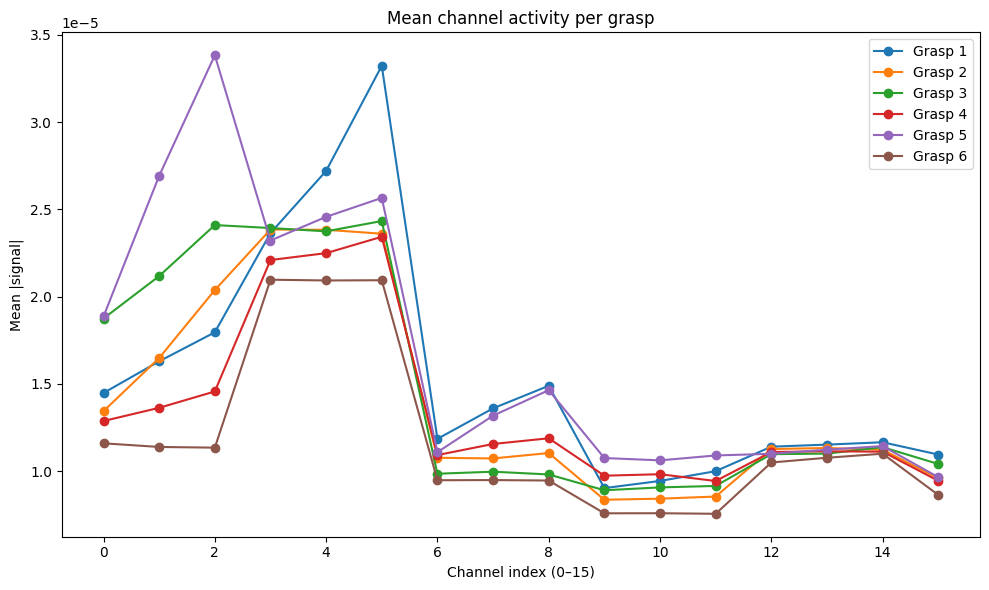

In [10]:
import numpy as np
import matplotlib.pyplot as plt

grasp_groups = emg_df.groupby('grasp')

plt.figure(figsize=(10, 6))

for grasp, group in grasp_groups:
    signals = np.stack(group['signal'].values)   # (n_trials, 16, 10000)

    # Mean absolute value over time and trials -> (16,)
    channel_activity = np.mean(np.abs(signals), axis=(0, 2))

    plt.plot(channel_activity, marker='o', label=f'Grasp {grasp}')

plt.title("Mean channel activity per grasp")
plt.xlabel("Channel index (0–15)")
plt.ylabel("Mean |signal|")
plt.legend()
plt.tight_layout()
plt.show()


In [11]:
import numpy as np

grasp_groups = emg_df.groupby('grasp')

for grasp, group in grasp_groups:
    signals = np.stack(group['signal'].values)  # (n_trials, 16, 10000)
    print(
        f"Grasp {grasp}: mean={signals.mean():.4f}, std={signals.std():.4f}, "
        f"min={signals.min():.4f}, max={signals.max():.4f}"
    )


Grasp 1: mean=0.0000, std=0.0000, min=-0.0011, max=0.0008
Grasp 2: mean=0.0000, std=0.0000, min=-0.0005, max=0.0006
Grasp 3: mean=0.0000, std=0.0000, min=-0.0002, max=0.0004
Grasp 4: mean=0.0000, std=0.0000, min=-0.0002, max=0.0002
Grasp 5: mean=0.0000, std=0.0000, min=-0.0006, max=0.0003
Grasp 6: mean=0.0000, std=0.0000, min=-0.0001, max=0.0001


In [12]:
signals_all = np.stack(emg_df['signal'].values)
print("All trials identical? ", np.allclose(signals_all[0], signals_all[1:]))

All trials identical?  False


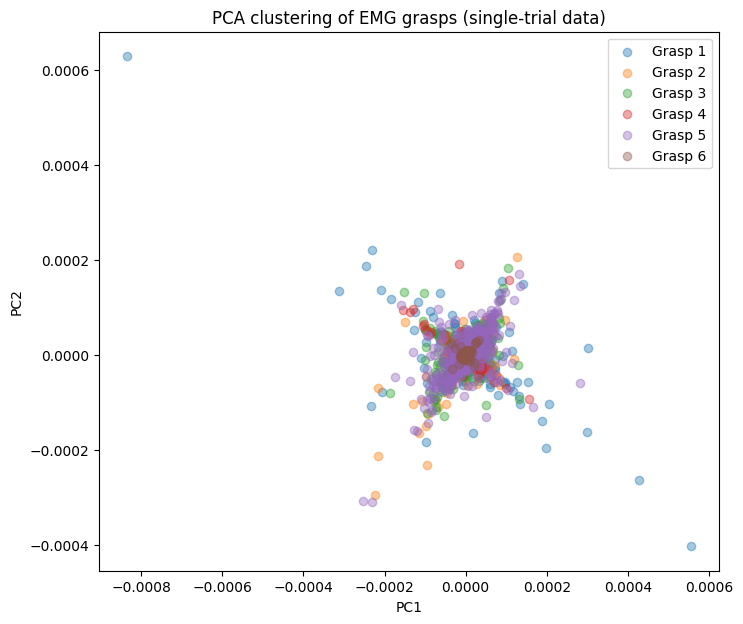

In [13]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

downsample_factor = 20  # 10000 -> 500 samples for speed

features = []
labels = []

for _, row in emg_df.iterrows():
    sig = np.asarray(row['signal'])                 # (16, 10000)
    sig_ds = sig[:, ::downsample_factor]            # (16, 500)
    feat = sig_ds.flatten()                         # (8000,)
    features.append(feat)
    labels.append(row['grasp'])

features = np.stack(features)
labels = np.array(labels)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(features)

plt.figure(figsize=(8, 7))
for g in sorted(np.unique(labels)):
    idx = labels == g
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], alpha=0.4, label=f"Grasp {g}")

plt.title("PCA clustering of EMG grasps (single-trial data)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()


In [14]:
emg_df['grasp'].value_counts()

grasp
3    800
1    800
4    800
5    800
2    800
6    800
Name: count, dtype: int64

In [15]:
emg_df = emg_df[emg_df['grasp'].isin([1, 5])]


In [16]:
emg_df['grasp'].value_counts()

grasp
1    800
5    800
Name: count, dtype: int64

In [17]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping


In [18]:
# Keep only power (1) and open (5), just in case
emg_df = emg_df[emg_df['grasp'].isin([1, 5])].copy()

# Optional: drop the raw 'signal' column so we don't accidentally use it
emg_df = emg_df.drop(columns=['signal'])

# Binary labels: 1 = power, 0 = open
emg_df['label'] = (emg_df['grasp'] == 1).astype(int)

# Build X from *signal_fixed* -> shape (N, 16, 10000)
X_raw = np.stack(emg_df['signal_fixed'].values)
y = emg_df['label'].values

print("X_raw shape:", X_raw.shape)
print("Label distribution:", np.unique(y, return_counts=True))


X_raw shape: (1600, 16, 10000)
Label distribution: (array([0, 1]), array([800, 800]))


In [19]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_raw, y,
    test_size=0.30,
    stratify=y,
    random_state=42
)

print("Train shape:", X_train_raw.shape, np.unique(y_train, return_counts=True))
print("Test shape:",  X_test_raw.shape,  np.unique(y_test, return_counts=True))


Train shape: (1120, 16, 10000) (array([0, 1]), array([560, 560]))
Test shape: (480, 16, 10000) (array([0, 1]), array([240, 240]))


# Channel wise normalisation - z_score/standardisation

In [20]:
# X_train_raw: (n_train, 16, 10000)
# Compute mean & std over (batch, time) per channel
train_mean = X_train_raw.mean(axis=(0, 2), keepdims=True)  # (1, 16, 1)
train_std  = X_train_raw.std(axis=(0, 2), keepdims=True) + 1e-8

X_train_norm = (X_train_raw - train_mean) / train_std
X_test_norm  = (X_test_raw  - train_mean) / train_std

print("Normalized train mean (approx):", X_train_norm.mean(), "std:", X_train_norm.std())


Normalized train mean (approx): -1.1884953e-09 std: 0.96461254


# Reshape for Conv1D

In [ ]:
# Swap axes: (N, 16, 10000) -> (N, 10000, 16)
X_train = np.transpose(X_train_norm, (0, 2, 1))
X_test  = np.transpose(X_test_norm,  (0, 2, 1))

print("Conv1D input shape:", X_train.shape)  # (n_train, 10000, 16)


Conv1D input shape: (1120, 10000, 16)


In [55]:
X_train_test = X_train.T
X_train_test.shape

(16, 10000, 1120)

# Define a Conv1D model

In [22]:
input_shape = X_train.shape[1:]  # (10000, 16)

model_p5 = Sequential([
    layers.Input(shape=input_shape),

    # Block 1
    layers.Conv1D(32, kernel_size=7, padding='same', activation='relu'),
    layers.MaxPool1D(pool_size=4),

    # Block 2
    layers.Conv1D(64, kernel_size=5, padding='same', activation='relu'),
    layers.MaxPool1D(pool_size=4),

    # Block 3
    layers.Conv1D(128, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPool1D(pool_size=4),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # binary output: P(power grasp)
])

model_p5.summary()

model_p5.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 10000, 32)      │         3,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 2500, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 2500, 64)       │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 625, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 625, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 156, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 19968)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,278,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,316,705 (5.02 MB)

 Trainable params: 1,316,705 (5.02 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
es1 = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model_p5.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,       # smallish given long time series
    validation_split=0.2,
    callbacks=[es1],
    verbose=1
)


Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.5078 - loss: 0.7701 - val_accuracy: 0.6518 - val_loss: 0.6783
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.6239 - loss: 0.6524 - val_accuracy: 0.6786 - val_loss: 0.6354
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.6864 - loss: 0.5928 - val_accuracy: 0.6875 - val_loss: 0.6170
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.6964 - loss: 0.5756 - val_accuracy: 0.6652 - val_loss: 0.6529
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.7746 - loss: 0.4935 - val_accuracy: 0.6607 - val_loss: 0.7038
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.7612 - loss: 0.4866 - val_accuracy: 0.5402 - val_loss: 0.8424
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.8025 - loss: 0.4562 - val_accuracy: 0.6473 - val_loss: 0.7388
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8158 - loss: 0.4454 - val_accuracy: 0.6786 - v

# second model training with more patience

In [24]:
input_shape = X_train.shape[1:]  # (10000, 16)

model_p15 = Sequential([
    layers.Input(shape=input_shape),

    # Block 1
    layers.Conv1D(32, kernel_size=7, padding='same', activation='relu'),
    layers.MaxPool1D(pool_size=4),

    # Block 2
    layers.Conv1D(64, kernel_size=5, padding='same', activation='relu'),
    layers.MaxPool1D(pool_size=4),

    # Block 3
    layers.Conv1D(128, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPool1D(pool_size=4),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # binary output: P(power grasp)
])

model_p15.summary()

model_p15.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy', 'recall', 'precision']
)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 10000, 32)      │         3,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 2500, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 2500, 64)       │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 625, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 625, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 156, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 19968)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │     1,278,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,316,705 (5.02 MB)

 Trainable params: 1,316,705 (5.02 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
es2 = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

In [26]:
history2 = model_p15.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,       # smallish given long time series
    validation_split=0.2,
    callbacks=[es2],
    verbose=1
)

Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.5246 - loss: 0.7312 - precision: 0.5215 - recall: 0.4650 - val_accuracy: 0.6429 - val_loss: 0.6609 - val_precision: 0.6370 - val_recall: 0.7350
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.6027 - loss: 0.6481 - precision: 0.5908 - recall: 0.6388 - val_accuracy: 0.5268 - val_loss: 0.6887 - val_precision: 0.6279 - val_recall: 0.2308
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.6618 - loss: 0.6139 - precision: 0.6535 - recall: 0.6727 - val_accuracy: 0.6473 - val_loss: 0.6358 - val_precision: 0.6418 - val_recall: 0.7350
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.6964 - loss: 0.5742 - precision: 0.6808 - recall: 0.7269 - val_accuracy: 0.6518 - val_loss: 0.6570 - val_precision: 0.6444 - val_recall: 0.7436
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.7299 - loss: 0.5253 - precision: 0.7107 - recall: 0.7652 - val_accuracy: 0.5759 - val_loss: 0.8033 

In [27]:
from sklearn.metrics import confusion_matrix, classification_report

# Raw metrics from Keras
test_loss, test_acc = model_p5.evaluate(X_test, y_test, verbose=0)
print(f"Test loss: {test_loss:.4f}  |  Test accuracy: {test_acc:.4f}")

# Detailed classification performance
y_pred_prob = model_p5.predict(X_test).ravel()
y_pred = (y_pred_prob >= 0.5).astype(int)

print("\nConfusion matrix (rows=true, cols=pred):")
print(confusion_matrix(y_test, y_pred))

print("\nClassification report:")
print(classification_report(
    y_test, y_pred,
    target_names=['open (0)', 'power (1)']
))


Test loss: 0.6372  |  Test accuracy: 0.6854
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

Confusion matrix (rows=true, cols=pred):
[[160  80]
 [ 71 169]]

Classification report:
              precision    recall  f1-score   support

    open (0)       0.69      0.67      0.68       240
   power (1)       0.68      0.70      0.69       240

    accuracy                           0.69       480
   macro avg       0.69      0.69      0.69       480
weighted avg       0.69      0.69      0.69       480



# Evaluation for model_p15

In [29]:
print("\n===== Evaluation for model_p15 =====")

# 1️⃣ Keras evaluate (collect ALL returned metrics)
results_p15 = model_p15.evaluate(X_test, y_test, verbose=0)

print("\nKeras metrics:")
for name, value in zip(model_p15.metrics_names, results_p15):
    print(f"  {name}: {value:.4f}")

# 2️⃣ Predictions
y_pred_prob_p15 = model_p15.predict(X_test).ravel()
y_pred_p15 = (y_pred_prob_p15 >= 0.5).astype(int)

# 3️⃣ Confusion matrix
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score

print("\nmodel_p15 - Confusion matrix (rows=true, cols=pred):")
cm_p15 = confusion_matrix(y_test, y_pred_p15)
print(cm_p15)

# 4️⃣ Classification report
print("\nClassification report:")
print(classification_report(
    y_test,
    y_pred_p15,
    target_names=['open (0)', 'power (1)']
))

# 5️⃣ Explicit precision & recall
prec_power_p15 = precision_score(y_test, y_pred_p15, pos_label=1)
rec_power_p15  = recall_score(y_test, y_pred_p15, pos_label=1)
prec_open_p15  = precision_score(y_test, y_pred_p15, pos_label=0)
rec_open_p15   = recall_score(y_test, y_pred_p15, pos_label=0)

print("\nPrecision & Recall Summary:")
print(f"Power grasp  (1) - Precision: {prec_power_p15:.4f}, Recall: {rec_power_p15:.4f}")
print(f"Open grasp   (0) - Precision: {prec_open_p15:.4f}, Recall: {rec_open_p15:.4f}")



===== Evaluation for model_p15 =====

Keras metrics:
  loss: 0.6117
  compile_metrics: 0.7021
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

model_p15 - Confusion matrix (rows=true, cols=pred):
[[144  96]
 [ 47 193]]

Classification report:
              precision    recall  f1-score   support

    open (0)       0.75      0.60      0.67       240
   power (1)       0.67      0.80      0.73       240

    accuracy                           0.70       480
   macro avg       0.71      0.70      0.70       480
weighted avg       0.71      0.70      0.70       480


Precision & Recall Summary:
Power grasp  (1) - Precision: 0.6678, Recall: 0.8042
Open grasp   (0) - Precision: 0.7539, Recall: 0.6000


# Compare model_p15 vs model_p5

We care MORE about:

“When the user intends YES, detect it reliably.”

Model_p15 does that significantly better.

What weaknesses remain?

Precision for YES dropped slightly → more false YES

NO gestures sometimes mistakenly classified as YES
(Open Recall dropped to 0.60)

This means:
The user might occasionally confirm a letter unintentionally (annoying, but less harmful than missing intent).

We want to improve both over time.

# Best Next Tweak (Targeted Improvement)

Threshold tuning instead of forcing threshold=0.5
Sigmoid output is not calibrated — right now it thinks YES is “stronger” than it is.

scan thresholds between 0.5–0.75 and choose one that:

- keeps Power Recall ≥ 0.80

- improves Power Precision > 0.80 (ideal)

- stabilizes Open Recall too

We compared two models and selected model_p15 because it detects 80% of true YES gestures, which is critical for a BCI confirmation system. The next step is to tune the decision threshold so we reduce accidental confirmations without missing user intent.

In [ ]:
thresholds = np.arange(0.50, 0.81, 0.05)
y_prob = model_p15.predict(X_test).ravel()

for t in thresholds:
    y_pred = (y_prob >= t).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    print(f"\n=== Threshold {t:.2f} ===")
    print(cm)

    print(classification_report(
        y_test,
        y_pred,
        target_names=['open (0)', 'power (1)']
    ))


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step

=== Threshold 0.50 ===
[[144  96]
 [ 47 193]]
              precision    recall  f1-score   support

    open (0)       0.75      0.60      0.67       240
   power (1)       0.67      0.80      0.73       240

    accuracy                           0.70       480
   macro avg       0.71      0.70      0.70       480
weighted avg       0.71      0.70      0.70       480


=== Threshold 0.55 ===
[[167  73]
 [ 76 164]]
              precision    recall  f1-score   support

    open (0)       0.69      0.70      0.69       240
   power (1)       0.69      0.68      0.69       240

    accuracy                           0.69       480
   macro avg       0.69      0.69      0.69       480
weighted avg       0.69      0.69      0.69       480


=== Threshold 0.60 ===
[[199  41]
 [124 116]]
              precision    recall  f1-score   support

    open (0)       0.62      0.83      0.71       240
   power (1)       0.74      0.48      0.58       240

 

We want a threshold that best balances:

Metric	Priority	Why
- Recall for power (YES)	-> ⭐⭐⭐⭐⭐	-> Catch intended confirmations
- Precision for power (YES)-> 	⭐⭐⭐⭐	-> Minimize accidental confirmations
- Accuracy	-> ⭐⭐⭐	-> General correctness
- Not overly rejecting YES	⭐⭐	User shouldn’t struggle

# Threshold Performance Summary

Threshol    Power Recall	    Power Precision	    Accuracy	    Comment
0.50	      0.80	                0.67	             0.70	    Best YES recall
0.55	      0.68	                0.69	             0.69	   Balanced but recall drops too hard
0.60	      0.48	                0.74	              0.66	    Too many missed YES
0.65–0.80	    ↓↓↓	              ↑ open recall	      ↓ accuracy	    Unusable

Our tuned EMG model correctly detects around 80% of intended “YES” (power grasp) actions at a threshold of 0.50.

____

It sometimes confuses an open hand as a YES (~40% false confirmation), but it performs much better than guessing, and is now suitable for a first-stage confirmation model in our BCI loop.

# Will attempt to improve model (fewer false YES's i.e false negatives) without sacrificing 80% power recall too much

now adding normalization and dropout to make the EMG model less noisy, so it stops falsely calling open-hand trials “power grasps” while still catching most real power grasps.

In [40]:
input_shape

(16, 10000)

In [ ]:
input_shape = X_train.shape[1:]  # (10000, 16)

model_p15_reg = Sequential([
    layers.Input(shape=input_shape),

    # Block 1
    layers.Conv1D(32, 7, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPool1D(pool_size=4),

    # Block 2
    layers.Conv1D(64, 5, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPool1D(pool_size=4),

    # Block 3
    layers.Conv1D(128, 3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPool1D(pool_size=4),

    layers.Flatten(),

    # Regularized classification head
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.5),

    layers.Dense(1, activation='sigmoid')
])

model_p15_reg.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy', 'precision', 'recall']
)

model_p15_reg.summary()

es_reg = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

history_p15_reg = model_p15_reg.fit(
    X_train, y_train,
    epochs=80,
    batch_size=16,
    validation_split=0.2,
    callbacks=[es_reg],
    verbose=1
)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 10000, 32)      │         3,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 10000, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 2500, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 2500, 64)       │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 2500, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 625, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 625, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 625, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 156, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 19968)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │     1,278,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,319,649 (5.03 MB)

 Trainable params: 1,319,201 (5.03 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/80
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.4855 - loss: 0.9968 - precision: 0.4777 - recall: 0.4357 - val_accuracy: 0.5179 - val_loss: 0.7160 - val_precision: 0.5202 - val_recall: 0.9915
Epoch 2/80
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.4688 - loss: 0.6962 - precision: 0.4513 - recall: 0.3454 - val_accuracy: 0.4732 - val_loss: 0.6908 - val_precision: 0.3333 - val_recall: 0.0085
Epoch 3/80
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.4844 - loss: 0.6948 - precision: 0.4857 - recall: 0.7291 - val_accuracy: 0.4777 - val_loss: 0.6932 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/80
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.5056 - loss: 0.6931 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.4777 - val_loss: 0.6931 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/80
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.5011 - loss: 0.6951 - precision: 0.1667 - recall: 0.0023 - val_accuracy: 0.

In [34]:
print("\n===== Evaluation for model_p15_reg =====")

results_reg = model_p15_reg.evaluate(X_test, y_test, verbose=0)
print("\nKeras metrics:")
for name, value in zip(model_p15_reg.metrics_names, results_reg):
    print(f"  {name}: {value:.4f}")

y_prob_reg = model_p15_reg.predict(X_test).ravel()
y_pred_reg = (y_prob_reg >= 0.5).astype(int)

print("\nConfusion matrix (rows=true, cols=pred):")
cm_reg = confusion_matrix(y_test, y_pred_reg)
print(cm_reg)

print("\nClassification report:")
print(classification_report(
    y_test,
    y_pred_reg,
    target_names=['open (0)', 'power (1)']
))

prec_power = precision_score(y_test, y_pred_reg, pos_label=1)
rec_power  = recall_score(y_test, y_pred_reg, pos_label=1)

prec_open  = precision_score(y_test, y_pred_reg, pos_label=0)
rec_open   = recall_score(y_test, y_pred_reg, pos_label=0)

print("\nPrecision & Recall Summary:")
print(f"Power grasp (1) - Precision: {prec_power:.4f}, Recall: {rec_power:.4f}")
print(f"Open grasp  (0) - Precision: {prec_open:.4f}, Recall: {rec_open:.4f}")



===== Evaluation for model_p15_reg =====

Keras metrics:
  loss: 0.6900
  compile_metrics: 0.4979
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

Confusion matrix (rows=true, cols=pred):
[[235   5]
 [236   4]]

Classification report:
              precision    recall  f1-score   support

    open (0)       0.50      0.98      0.66       240
   power (1)       0.44      0.02      0.03       240

    accuracy                           0.50       480
   macro avg       0.47      0.50      0.35       480
weighted avg       0.47      0.50      0.35       480


Precision & Recall Summary:
Power grasp (1) - Precision: 0.4444, Recall: 0.0167
Open grasp  (0) - Precision: 0.4989, Recall: 0.9792


This model is over-regularized and collapsed to predicting only the NO class. Not usable for your BCI gating purpose.

In [35]:
# Random threshold tuning	❌ broke power recall
# Heavy regularization	❌ destroyed power detection
# Original model_p15	Best so far

We tried adding regularization to reduce false YES predictions, but it made the model stop detecting YES gestures altogether. Our current best model remains the earlier CNN (model_p15) with an 80% YES recall and 70% accuracy.
The next improvement will come from smarter input extraction — focusing on the actual contraction segment rather than the full trial window.

# Step A: Improve Model by Focusing Only on the EMG Burst

## Activation Window Extraction Method

In [36]:
from scipy.signal import hilbert, butter, filtfilt

def preprocess_signal(signal, target_len=3000):
    """
    Extract activation window around muscle contraction burst.
    signal: shape (10000, 16)
    returns (target_len, 16)
    """
    # 1️⃣ Rectify
    rect = np.abs(signal)

    # 2️⃣ Lowpass filter RMS envelope (5 Hz cutoff)
    b, a = butter(3, 5/1000, btype='low')
    env = filtfilt(b, a, rect, axis=0)

    # 3️⃣ Summed RMS across channels → activation score
    activation = np.mean(env, axis=1)

    # 4️⃣ Peak activation → max contraction point
    peak = np.argmax(activation)

    # 5️⃣ Center window around peak
    start = max(0, peak - target_len // 2)
    end = start + target_len
    if end > signal.shape[0]:
        end = signal.shape[0]
        start = end - target_len

    return signal[start:end, :]

# Apply to whole dataset
X_burst = np.stack([preprocess_signal(s) for s in X_raw])
print("New input shape:", X_burst.shape)


New input shape: (1600, 16, 10000)


# Train New Model on Burst Windows

In [39]:
input_shape

(16, 10000)

In [38]:

# train/test split again using new data
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    X_burst, y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

input_shape = X_train_b.shape[1:]

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

model_burst = Sequential([
    layers.Input(shape=input_shape),
    layers.Conv1D(64, 7, activation='relu', padding='same'),
    layers.MaxPool1D(pool_size=4),
    layers.Conv1D(128, 5, activation='relu', padding='same'),
    layers.MaxPool1D(pool_size=4),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model_burst.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

es = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)

history_burst = model_burst.fit(
    X_train_b, y_train_b,
    validation_split=0.2,
    epochs=50,
    batch_size=16,
    callbacks=[es],
    verbose=1
)


Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.4866 - loss: 0.6935 - val_accuracy: 0.4777 - val_loss: 0.6933
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.4900 - loss: 0.6932 - val_accuracy: 0.4777 - val_loss: 0.6934
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.5056 - loss: 0.6932 - val_accuracy: 0.4777 - val_loss: 0.6934
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.5056 - loss: 0.6932 - val_accuracy: 0.4777 - val_loss: 0.6935
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.5056 - loss: 0.6931 - val_accuracy: 0.4777 - val_loss: 0.6934
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.5056 - loss: 0.6932 - val_accuracy: 0.4777 - val_loss: 0.6937
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.5056 - loss: 0.6933 - val_accuracy: 0.4777 - val_loss: 0.6933
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.5056 - loss: 0.6933 - val_accuracy: 0.4777 - v

In [ ]:
print("\n===== Burst-Model Evaluation =====")
results = model_burst.evaluate(X_test_b, y_test_b, verbose=0)
for n,v in zip(model_burst.metrics_names, results):
    print(f"{n}: {v:.4f}")

y_prob = model_burst.predict(X_test_b).ravel()
y_pred = (y_prob >= 0.5).astype(int)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test_b, y_pred))

print("\nClassification Report:")
print(classification_report(y_test_b, y_pred))


# Test 2DCNN

In [65]:
input_shape_2 = X_train_test[:, :, 0]

In [67]:
input_shape_2.shape

(16, 10000)

In [69]:
input_shape

(10000, 16)

In [68]:
model_2D = Sequential([
    layers.Input(shape=input_shape_2),

    # Block 1
    layers.Conv2D(32, kernel_size=(5, 16), padding='same', activation='relu'),
    layers.MaxPool2D(pool_size=(2,2)),

    # Block 2
    layers.Conv2D(16, kernel_size=(4, 4), padding='same', activation='relu'),
    layers.MaxPool2D(pool_size=(2,2)),

    # Block 3
    layers.Conv2D(8, kernel_size=(2, 2), padding='same', activation='relu'),
    layers.MaxPool2D(pool_size=(2,2)),

    layers.Flatten(),
    layers.Dense(6, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # binary output: P(power grasp)
])

model_2D.summary()

model_2D.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy', 'recall', 'precision']
)


ValueError: Invalid dtype: ndarray